Uses tensorforce tensorforce-0.3.0

Took 8 million steps over about a day to warm up. Got 1.6e-4 which is about 25% a month, 25x a year.


In [1]:
# plotting
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# numeric
import numpy as np
from numpy import random
import pandas as pd
import tensorflow as tf

# util
from collections import Counter
import pdb
import glob
import time
import tempfile
import itertools
from tqdm import tqdm_notebook as tqdm
import datetime

# logging
import logging
logger = log = logging.getLogger(__name__)
# log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

In [2]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding

In [3]:
import os
os.sys.path.append(os.path.abspath('.'))
%reload_ext autoreload
%autoreload 2

In [4]:
# params
window_length = 50
cash_bias = 0.0
batch_size=128
import datetime
ts = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')
save_path = './outputs/tensorforce-PPO-prioritised/tensorforce-PPO-crypto-%s.model' % ts
save_path = './outputs/tensorforce-PPO-prioritised/tensorforce-PPO-crypto-20171105_06-50-31.model'
save_path

'./outputs/tensorforce-PPO-prioritised/tensorforce-PPO-crypto-20171105_06-50-31.model'

In [5]:
log_dir = os.path.join('logs', os.path.splitext(os.path.basename(save_path))[0], 'run-' + ts)
try:
    os.makedirs(log_dir)
except OSError:
    pass
log_dir

'logs/tensorforce-PPO-crypto-20171105_06-50-31/run-20171111_08-57-19'

# Enviroment

We will wrap out environment so we can modify the inputs, outputs, and attributes for tensorforce.

- tensorforce doesn't like dual outputs so we will concat them
- we need to softmax the weights since tensorforce doesn't do this

In [6]:
from rl_portfolio_management.environments.portfolio import PortfolioEnv

In [7]:
# We need to wrap the env to make sure the output is softmaxed

import gym.spaces
df_train = pd.read_hdf('./data/poloniex_30m.hf',key='train')
    
def softmax(w, t = 1.0):
    w = np.clip(w, -10, 10) # same as clipping to 1e-5 1e5
    e = np.exp(np.array(w) / t)
    dist = e / np.sum(e + 1e-7)
    return dist

class EnvWrapper(PortfolioEnv):
    """Wraps env to normalise and reshape action."""
    def __init__(self, window_length=50, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        hist_space = self.observation_space.spaces["history"]
        hist_shape = hist_space.shape
        self.observation_space = gym.spaces.Box(-10,10,shape=(hist_shape[0],hist_shape[1]+1,hist_shape[2]))
        
    def step(self, action):
        # also it puts it in a list
        if isinstance(action, list):
            action = action[0]
        
        if isinstance(action, dict):
            action = list(action[k] for k in sorted(action.keys()))
        
        action = softmax(action, t=1)
        
        state, reward, done, info = super().step(action)
        history = state["history"]
        weights = state["weights"]
        weight_insert_shape = (history.shape[0], 1, history.shape[2])
        weight_insert = np.ones(
            weight_insert_shape) * weights[1:, np.newaxis, np.newaxis]
        state = np.concatenate([history, weight_insert], axis=1)

        return state, reward, done, info

In [8]:
# tensorforce wants us to use this wrapper, our subclass lets us pass in an env as an object
from tensorforce.contrib.openai_gym import OpenAIGym
class CustomOpenAIGym(OpenAIGym):
    def __init__(self, gym_id, gym):
        self.gym_id = gym_id
        self.gym = gym

In [9]:
df_train = pd.read_hdf('./data/poloniex_30m.hf',key='train')
env = EnvWrapper(
    df=df_train,
    steps=40, 
    scale=True, 
    trading_cost=0.0025, 
    window_length = window_length,
    output_mode='EIIE',
)
env.seed(0)
environment = CustomOpenAIGym('CryptoPortfolioEIIE-v0', env)

df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')
env_test = EnvWrapper(
    df=df_test,
    steps=40, 
    scale=True, 
    trading_cost=0.0025, 
    window_length=window_length,
    output_mode='EIIE',
)
env_test.seed(0)

environment_test = CustomOpenAIGym('CryptoPortfolioEIIETest-v0', env_test)

In [10]:
# sanity check out environment is working
state = env.reset()
state, reward, done, info=env.step(env.action_space.sample())
state.shape

(3, 51, 3)

# Model

Derived from  https://github.com/reinforceio/tensorforce/blob/0d07fadec03f76537a2431e17c51cd759d53b5e9/tensorforce/core/networks/layers.py#L90

Implemented as per CNN version of https://arxiv.org/abs/1706.10059 

In [11]:
from tensorforce import Configuration
from tensorforce.agents import PPOAgent
from tensorforce.core.networks import LayeredNetwork, layers, Network, network

In [12]:
from tensorforce.core.networks import Layer, Conv2d, Nonlinearity
class EIIE(Layer):
    """
    EIIE layer
    """

    def __init__(self,
                 size=20,
                 bias=True,
                 activation='relu',
                 l2_regularization=0.0,
                 l1_regularization=0.0,
                 scope='EIIE',
                 summary_labels=()):
        self.size = size
        # Expectation is broadcast back over advantage values so output is of size 1
        self.conv1 = Conv2d(
            size=3,
            bias=bias,
            stride=(1,1),
            window=(1,3),
            padding='VALID',
            l2_regularization=l2_regularization,
            l1_regularization=l1_regularization,
            summary_labels=summary_labels)
        self.conv2 = Conv2d(
            size=size,
            bias=bias,
            stride=(1,window_length-2-1),
            window=(1,window_length-2-1),
            padding='VALID',
            l2_regularization=l2_regularization,
            l1_regularization=l1_regularization,
            summary_labels=summary_labels)
        self.conv3 = Conv2d(
            size=1,
            bias=bias,
            stride=(1,1),
            window=(1,1),
            l2_regularization=l2_regularization,
            l1_regularization=l1_regularization,
            summary_labels=summary_labels)
        self.nonlinearity = Nonlinearity(
            name=activation, summary_labels=summary_labels)
        self.nonlinearity2 = Nonlinearity(
            name=activation, summary_labels=summary_labels)
        super(EIIE, self).__init__(
            scope=scope, summary_labels=summary_labels)

    def tf_apply(self, x0, update):
        # where window_size=50, actions=4 (giving the 3), data cols=5
        # x0 = (None,3,50,5)
        # x = (None,3,49,5)
        # x = (None,3,1,1)
        # conv1 => (None,3, 47,3)
        # conv2 => (None,3, 1, 20)
        # concat=> (None,3, 1, 21)
        # conv3 => (None,3, 1, 1)
        # concat=> (None,2, 1, 1)

        w0 = x0[:,:,:1,:1]
        x = x0[:,:,1:,:]
        
        x = self.conv1.apply(x, update=update)
        x = self.nonlinearity.apply(x=x, update=update)
        
        x = self.conv2.apply(x, update=update)
        x = self.nonlinearity2.apply(x=x, update=update)
        
        x = tf.concat([x, w0], 3)
        x = self.conv3.apply(x, update=update)
        
        # concat on cash_bias
        cash_bias_int = 0
        # FIXME not sure how to make shape with a flexible size in tensorflow but this works for now
        # cash_bias = tf.ones(shape=(batch_size,1,1,1)) * cash_bias_int
        cash_bias = x[:,:1,:1,:1]*0 
        x = tf.concat([cash_bias, x], 1)

        if 'activations' in self.summary_labels:
            summary = tf.summary.histogram(name='activations', values=x)
            self.summaries.append(summary)

        return x

    def tf_regularization_loss(self):
        if super(EIIE, self).tf_regularization_loss() is None:
            losses = list()
        else:
            losses = [super(EIIE, self).tf_regularization_loss()]

        if self.conv1.regularization_loss() is not None:
            losses.append(self.conv1.regularization_loss())
        if self.conv2.regularization_loss() is not None:
            losses.append(self.conv2.regularization_loss())
        if self.conv1.regularization_loss() is not None:
            losses.append(self.conv3.regularization_loss())

        if len(losses) > 0:
            return tf.add_n(inputs=losses)
        else:
            return None

    def get_variables(self, include_non_trainable=False):
        layer_variables = super(EIIE, self).get_variables(
            include_non_trainable=include_non_trainable)

        layer_variables += self.conv1.get_variables(
            include_non_trainable=include_non_trainable)
        layer_variables += self.conv2.get_variables(
            include_non_trainable=include_non_trainable)
        layer_variables += self.conv3.get_variables(
            include_non_trainable=include_non_trainable)

        layer_variables += self.nonlinearity.get_variables(
            include_non_trainable=include_non_trainable)
        layer_variables += self.nonlinearity.get_variables(
            include_non_trainable=include_non_trainable)

        return layer_variables
    
# Add our custom layer
layers['EIIE'] = EIIE

# Network as list of layers
network_spec = [
    dict(type='EIIE', 
         l1_regularization=1e-8,
        l2_regularization=1e-8),
    dict(type='flatten')
]

In [13]:
# also add a custom baseline
from tensorforce.core.baselines import NetworkBaseline
from tensorforce.core.baselines import baselines


class EIIEBaseline(NetworkBaseline):
    """
    CNN baseline (single-state) consisting of convolutional layers followed by dense layers.
    """

    def __init__(self, layers_spec, scope='eiie-baseline', summary_labels=()):
        """
        CNN baseline.
        Args:
            conv_sizes: List of convolutional layer sizes
            dense_sizes: List of dense layer sizes
        """

        super(EIIEBaseline, self).__init__(layers_spec, scope, summary_labels)
        
# Add our custom baseline
baselines['EIIE']=EIIEBaseline

# Agent


In [14]:

exploration=dict(
    type="epsilon_anneal",
    epsilon=1,
    epsilon_final= 0.005,
    epsilon_timesteps= 1e5,
    start_after=0,
)

# exploration = tensorforce.core.explorations.EpsilonAnneal(**exploration)
config = Configuration( 
    batch_size=batch_size,
    
    # Each agent requires the following ``Configuration`` parameters:
    preprocessing = None,# dict or list containing state preprocessing configuration.
    exploration = exploration, #{'action' + str(n): exploration for n in range(env.action_space.shape[0])}, # dict containing action exploration configuration.
    reward_preprocessing=None,
    
    # BatchAgent
    keep_last_timestep=True,

    # PPOAgent
    step_optimizer=dict(
        type='adam',
        learning_rate = 3e-5, # float of learning rate (alpha). (3e-4 in paper 1e-3 (atari) and 3e-4 in baselines)
    ),
    optimization_steps=4,
    
    # Each model requires the following configuration parameters:
    # https://github.com/reinforceio/tensorforce/blob/master/tensorforce/models/model.py#L33
    scope='ppo',
    discount = 0.97, # float of discount factor (gamma).
    
    # DistributionModel
    distributions=dict(action=dict(type='gaussian', mean=0.25, log_stddev=np.log(5e-2))),
#     distributions=dict(type='beta', min_value, max_value, alpha=0.0, beta=0.0)
    entropy_regularization=0.01, # 0 and 0.01 in baselines
    
    # PGModel
#     baseline_mode='network', # states or network
    baseline_mode='states',
    baseline=dict(
        type="EIIE",
        layers_spec=network_spec
#         update_batch_size=512,
    ), # string indicating the baseline value function (currently 'linear' or 'mlp').
    baseline_optimizer=dict(type='adam', learning_rate=0.01),
    gae_lambda=0.5,
    normalize_rewards=False,
    
    # PGLRModel
    likelihood_ratio_clipping=0.2,  # Trust region clipping 0.2 in paper
    
    # Logging
    log_level = 'info', # string containing log level (e.g. 'info').
    
    # Tensorflow summaries
    summary_logdir = log_dir, # string directory to write tensorflow summaries. Default None
    summary_labels=['total-loss'],
    summary_frequency=10,
    
    # TensorFlow distributed configuration
    cluster_spec=None,
    parameter_server=False,
    task_index=0,
    device=None,
    local_model=False,
    replica_model=False,)

# I want to use a gaussian dist instead of beta, we will apply post processing to scale everything
actions_spec = environment.actions.copy()
del actions_spec["min_value"]
del actions_spec["max_value"]

# Create an agent
agent = PPOAgent(
    states_spec=environment.states,
    actions_spec=actions_spec,
    network_spec=network_spec,
    config=config
)
agent

[2017-11-11 16:57:37,867] Configuration values not accessed: summary_labels, summary_frequency, task_index, distributions, local_model, cluster_spec, replica_model, parameter_server, summary_logdir


In [15]:
from tensorforce.execution import Runner
runner = Runner(agent=agent, environment=environment)

# Train

## Callbacks

In [16]:
from rl_portfolio_management.callbacks.tensorforce import EpisodeFinishedTQDM, EpisodeFinished
from rl_portfolio_management.util import MDD, sharpe

## Train

Widget Javascript not detected.  It may not be installed or enabled properly.


TensorBoardLogger started. Run `tensorboard --logdir=/media/oldhome/wassname/Documents/projects/rl-portfolio-gh/rl-portfolio-management/logs/tensorforce-PPO-crypto-20171105_06-50-31` to visualize
ep reward: -0.00004773 [-0.00032387,  0.00027298], portfolio_value:  0.9247 mdd=-2.42% sharpe=-2.0635, expl= 99.60% eps=10 weights={'DASHBTC': 0.6171000003814697, 'LTCBTC': 0.24709999561309814, 'XMRBTC': 0.08590000122785568}


<IPython.core.display.Javascript object>


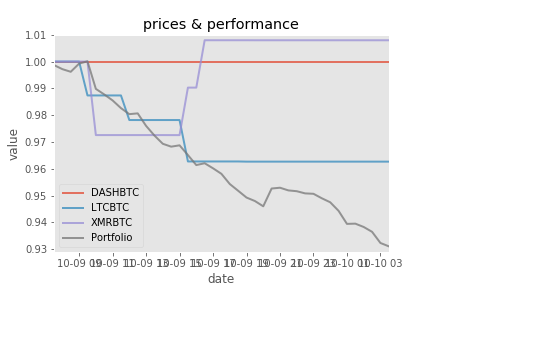

<IPython.core.display.Javascript object>


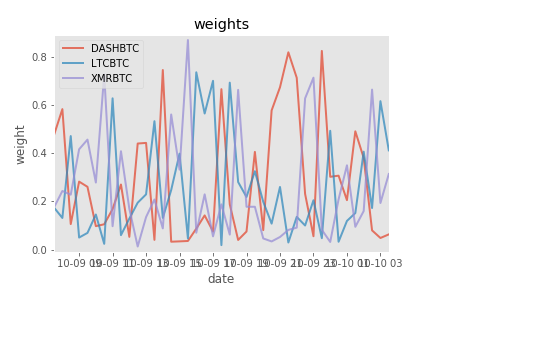

<IPython.core.display.Javascript object>


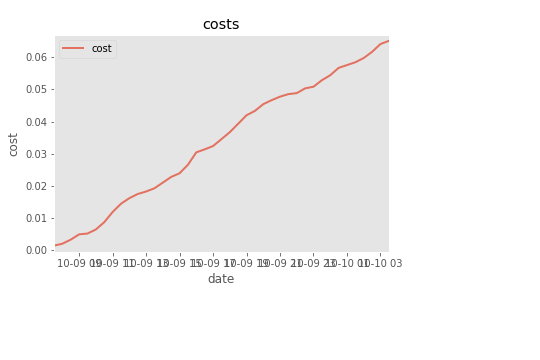

ep reward: -0.00001556 [-0.00029678,  0.00021174], portfolio_value:  0.9748 mdd=-2.05% sharpe=-0.9608, expl= 99.20% eps=20 weights={'DASHBTC': 0.06689999997615814, 'LTCBTC': 0.8021000027656555, 'XMRBTC': 0.08320000022649765}
ep reward: -0.00004355 [-0.00025847,  0.00017455], portfolio_value:  0.9311 mdd=-1.22% sharpe=-3.7503, expl= 98.80% eps=30 weights={'DASHBTC': 0.06350000202655792, 'LTCBTC': 0.41200000047683716, 'XMRBTC': 0.3138999938964844}


KeyboardInterrupt: 

In [17]:
%matplotlib notebook
steps=12e6
env._plot = env._plot2 = env._plot3 = None
episodes = int(steps / 30)
runner.run(
    timesteps=steps,
    episode_finished=EpisodeFinishedTQDM(
        log_intv=10,
        steps=steps,
        mean_of=10,
        log_dir=log_dir,
        session=runner.agent.model.session,
    )
)

In [18]:
# read history, might be slow
import collections
import glob
from tensorflow.python.summary import summary_iterator
event_paths = glob.glob(os.path.join(log_dir, "event*"))
data = collections.defaultdict(dict)
for file in event_paths:
    event_reader = summary_iterator.summary_iterator(file)
    for event in tqdm(event_reader):
        try:
            step=event.step
            name=event.summary.value[0].tag
            val=event.summary.value[0].simple_value
            data[step][name]=val
        except:
            pass


Widget Javascript not detected.  It may not be installed or enabled properly.


<IPython.core.display.Javascript object>


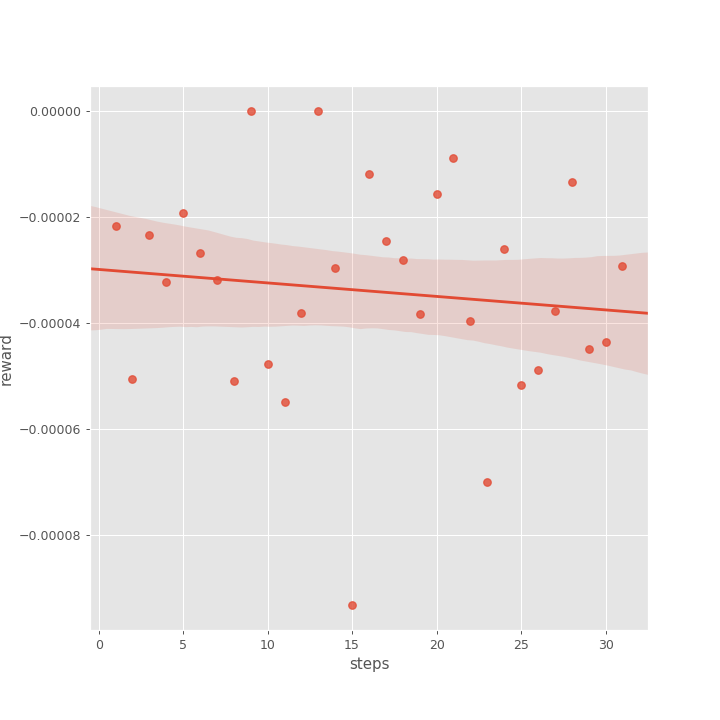

In [19]:
# View history
df = pd.DataFrame(data).T
df

df["steps"]=df.index
plt.figure(figsize=(8,8))
sns.regplot(x="steps", y="reward", data=df, order=1)